In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd


In [3]:
PATH = "data/competitions/state-farm-distracted-driver-detection/"

sz=224
bs=24
arch=resnet50

In [4]:
ls {PATH}

driver_imgs_list.csv      models/                    test/   train_classes/
driver_imgs_list.csv.zip  sample_submission.csv      tmp/
imgs.zip                  sample_submission.csv.zip  train/


In [5]:
raw_label_csv = f'{PATH}driver_imgs_list.csv'
label_csv = 'f{PATH}train_driver.csv'

In [6]:
label_df = pd.read_csv(raw_label_csv)
n = len(label_df)

In [110]:
print(n)
label_df.head()
label_df.to_csv(label_csv, columns=['img', 'classname'], index=False)

22424


In [111]:
val_idxs = get_cv_idxs(n)
np.save(f'{PATH}tmp/val_idxs', val_idxs)

In [7]:
val_idxs = np.load(f'{PATH}tmp/val_idxs.npy')

In [8]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, bs=bs,
                                       tfms=tfms, val_idxs=val_idxs, test_name='test')
    return data

In [9]:
data = get_data(sz, bs)

In [115]:
files = os.listdir(f'{PATH}train')[:10000]

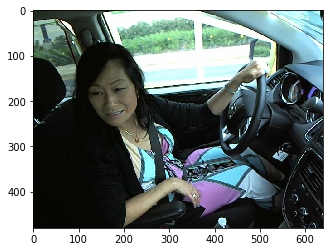

In [116]:
r_files = np.random.choice(files, 5)
img = plt.imread(f'{PATH}train/{r_files[1]}')
plt.imshow(img);

In [117]:
data.val_ds.fnames.shape

(4484,)

In [10]:
learn = ConvLearner.pretrained(arch, data, ps=0.5, precompute=False)

In [119]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 540/748 [00:05<00:02, 103.45it/s, loss=3.75]


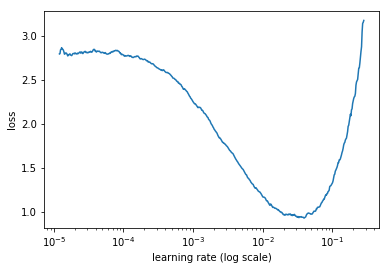

In [120]:
learn.sched.plot()

In [121]:
lr = 1e-3
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.915345   0.57726    0.874332  
    1      0.598559   0.349764   0.927005                     
    2      0.491167   0.25952    0.944831                     



[0.25952047, 0.9448306563703771]

In [122]:
learn.save('precomputed3')

In [122]:
learn.load('precomputed3')

In [125]:
learn.precompute=False
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.835574   0.275491   0.936364  
    1      0.759404   0.262202   0.934804                    
    2      0.63858    0.246528   0.941979                    



[0.24652842, 0.9419786069482405]

In [126]:
learn.save('augmented')

In [127]:
learn.load('augmented')

In [129]:
learn.unfreeze()
lrs = np.array([1e-5, 1e-4, 1e-3])
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 575/748 [02:34<00:46,  3.72it/s, loss=2.07] 

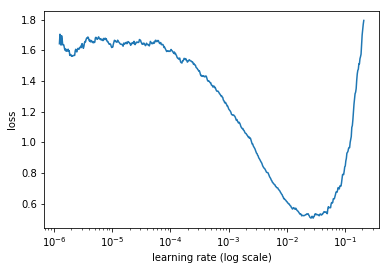

In [131]:
learn.sched.plot()

In [133]:
lrs = np.array([1e-6, 5e-5, 9e-4])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/748 [00:00<?, ?it/s]                     


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.519643   0.24152    0.934358  
    1      0.298051   0.130976   0.963815                    
    2      0.257438   0.120709   0.968271                    



[0.12070924, 0.9682709418516108]

In [134]:
learn.save('unfreeze_1')

In [11]:
learn.load('unfreeze_1')

In [140]:
learn.set_data(data)

In [ ]:
log_preds, y_preds = learn.TTA(is_test=True)